In [20]:
import cv2
import numpy as np                      
import pickle
from pupil_apriltags import Detector
import matplotlib.pyplot as plt
import glob

In [2]:
pickle_data = pickle.load(open("./aprildata/AprilBoards.pkl", "rb"))
at_coarseboard = pickle_data['at_coarseboard']
at_fineboard = pickle_data['at_fineboard']

In [3]:
def detect_aprilboard(img, board, apriltag_detector):
    # Usage:  imgpoints, objpoints, tag_ids = detect_aprilboard(img,board,AT_detector)
    #
    # Input: 
    #   image -- grayscale image
    #   board -- at_coarseboard or at_fineboard (list of dictionaries)
    #   AT_detector -- AprilTag Detector parameters
    #
    # Returns: 
    #   imgpoints -- Nx2 numpy array of (x,y) image coords
    #   objpoints -- Nx3 numpy array of (X,Y,Z=0) board coordinates (in inches)
    #   tag_ids -- Nx1 list of tag IDs
    
    imgpoints=[]
    objpoints=[]
    tagIDs=[]
    
    # detect april tags
    imgtags = apriltag_detector.detect(img, 
                                    estimate_tag_pose=False, 
                                    camera_params=None, 
                                    tag_size=None)

    if len(imgtags):
        # collect image coordinates of tag centers
        # imgpoints = np.vstack([ sub.center for sub in tags ])

        # list of all tag_id's that are in board
        brdtagIDs = [ sub['tag_id'] for sub in board ]

        # list of all detected tag_id's that are in image
        imgtagIDs = [ sub.tag_id for sub in imgtags ]

        # list of all tag_id's that are in both
        tagIDs = list(set(brdtagIDs).intersection(imgtagIDs))
        
        if len(tagIDs):
            # all board list-elements that contain one of the common tag_ids
            objs=list(filter(lambda tagnum: tagnum['tag_id'] in tagIDs, board))
            
            # their centers
            objpoints = np.vstack([ sub['center'] for sub in objs ])
    
            # all image list-elements that contain one of the detected tag_ids
            imgs=list(filter(lambda tagnum: tagnum.tag_id in tagIDs, imgtags))    
            
            # their centers
            imgpoints = np.vstack([ sub.center for sub in imgs ])
        
    return imgpoints, objpoints, tagIDs

./aprildata/data/img0.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img1.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img2.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img3.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img4.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img5.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img6.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img7.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img8.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img9.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img10.jpg, coarse: 35 imgpts, 35 objpts
./aprildata/data/img11.jpg, coarse: 35 imgpts, 35 objpts


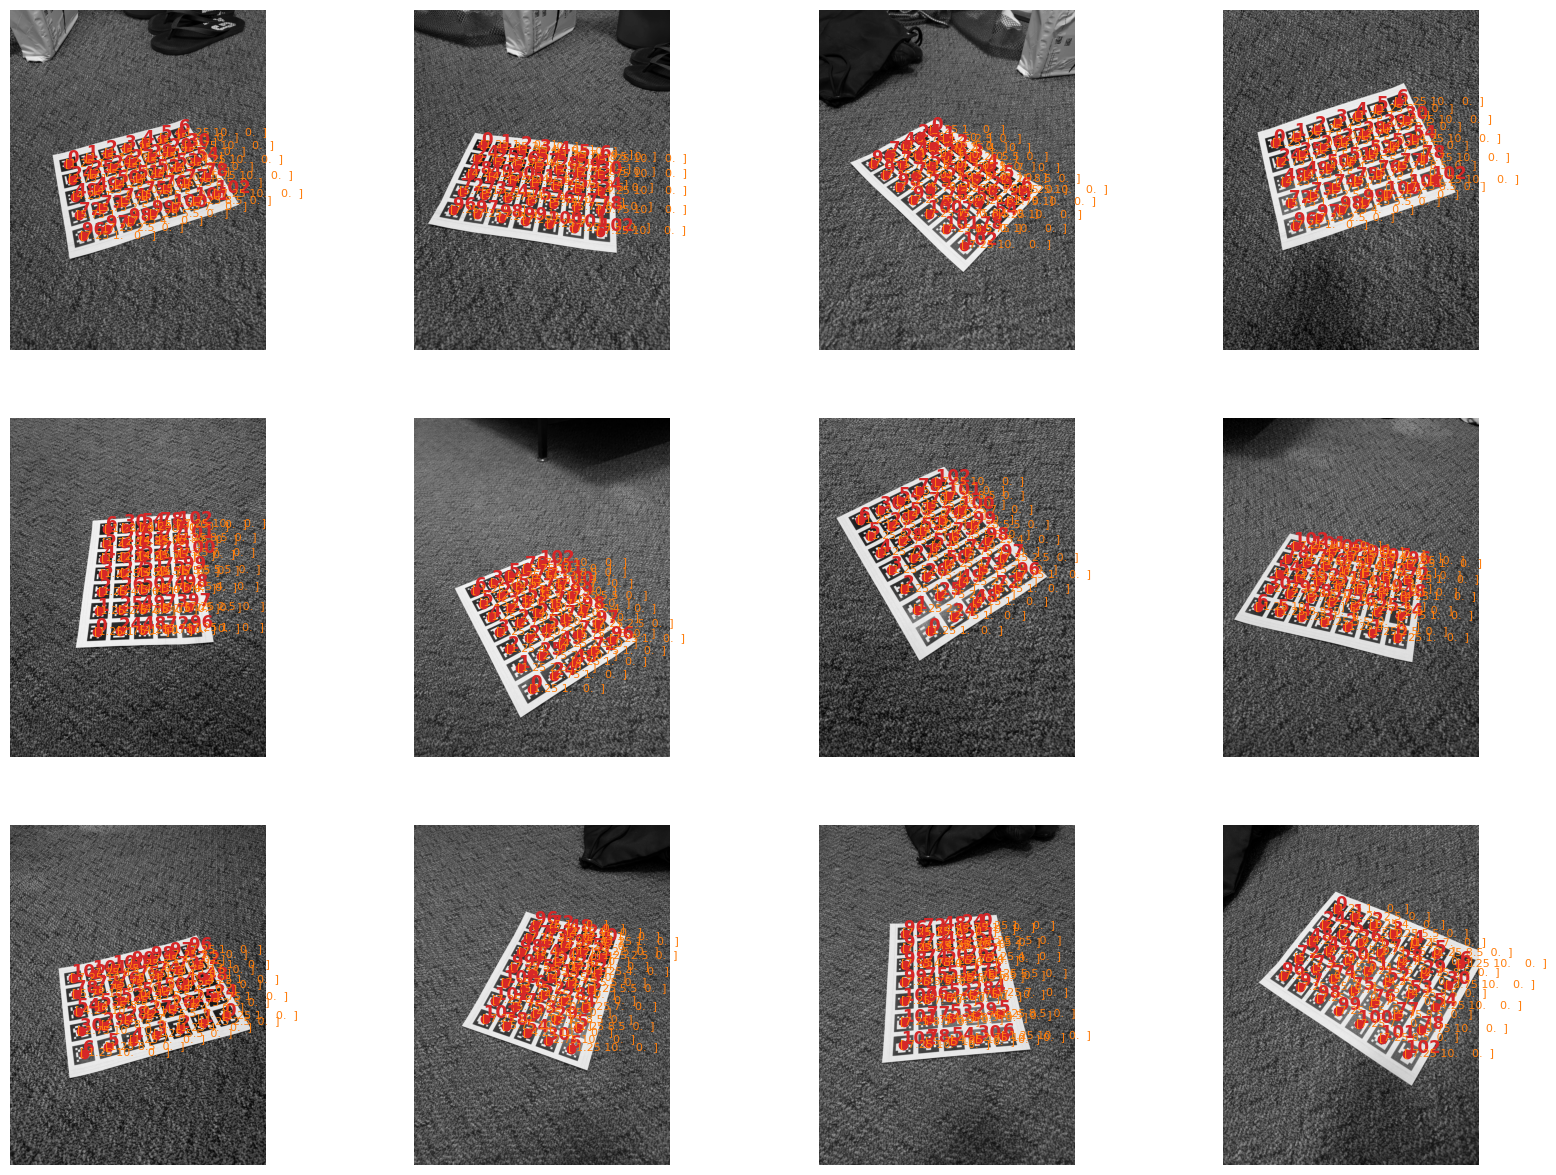

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(20,15))

for j in range(12):
    fname = f'./aprildata/data/img{j}.jpg'

    # read image and convert to grayscale if necessary
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig
        
    # set up april tag detector (I use default parameters; seems to be OK)
    at_detector = Detector(families='tag36h11',
                        nthreads=1,
                        quad_decimate=1.0,
                        quad_sigma=0.0,
                        refine_edges=1,
                        decode_sharpening=0.25,
                        debug=0)

    # detect "coarse" April Board only (would need to run again for other board)
    imgpoints_coarse, objpoints_coarse, tagIDs_coarse = detect_aprilboard(img,at_coarseboard,at_detector)
    print("{}, coarse: {} imgpts, {} objpts".format(fname, len(imgpoints_coarse),len(objpoints_coarse)))

    # verify by overlaying on grayscale image
    axs[j // 4][j % 4].imshow(img / 255.0, cmap="gray")
    axs[j // 4][j % 4].axis('off')

    for i in range(len(imgpoints_coarse)):
        
        # detected center location
        axs[j // 4][j % 4].plot(imgpoints_coarse[i,0], imgpoints_coarse[i,1],marker='o',color='#d62728')

        # tag ID (red)
        axs[j // 4][j % 4].text(imgpoints_coarse[i,0]-10,
                imgpoints_coarse[i,1]-10,
                "{} ".format(tagIDs_coarse[i]),
                color='#d62728',
                fontsize=12,
                fontweight='bold')    
        
        # coordinates (X,Y,0) in inches (orange)
        axs[j // 4][j % 4].text(imgpoints_coarse[i,0]-40,
                imgpoints_coarse[i,1]+20,
                np.array2string(objpoints_coarse[i,:]),
                color='#ff7f0e',
                fontsize=8)
        
plt.show()

In [ ]:
# Edit this line to point to the collection of input calibration image
CALIBFILES = './aprildata/data/img*.jpg'

# Uncomment one of the following two lines to indicate which AprilBoard is being used (fine or coarse)
# BOARD = at_fineboard
BOARD = at_coarseboard

###### BEGIN CALIBRATION SCRIPT

# exit if no images are found or if BOARD is unrecognized
images = glob.glob(CALIBFILES)
assert images, "no calibration images matching: " + CALIBFILES
assert BOARD==at_fineboard or BOARD==at_coarseboard, "Unrecognized AprilBoard"

images = [f'./aprildata/data/img{i}.jpg' for i in range(0, 6)]

# uncomment this line for verbose output
# print("{} images:".format(len(images)))

# initialize 3D object points and 2D image points
calObjPoints = []
calImgPoints = []

# set up april tag detector (I use default parameters; seems to be OK)
at_detector = Detector(families='tag36h11',
                       nthreads=1,
                       quad_decimate=1.0,
                       quad_sigma=0.0,
                       refine_edges=1,
                       decode_sharpening=0.25,
                       debug=0)

for count,fname in enumerate(images):
    
    # read image and convert to grayscale if necessary
    orig = cv2.imread(fname)
    if len(orig.shape) == 3:
        img = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    else:
        img = orig

    # detect apriltags and report number of detections
    imgpoints, objpoints, tagIDs = detect_aprilboard(img,BOARD,at_detector)
    
    # uncomment this line for verbose output
    #print("{} {}: {} imgpts, {} objpts".format(count, fname, len(imgpoints),len(objpoints)))
    
    # append detections if some are found
    if len(imgpoints) and len(objpoints):
            
        # append points detected in all images, (there is only one image now)
        calObjPoints.append(objpoints.astype('float32'))
        calImgPoints.append(imgpoints.astype('float32'))

# convert to numpy array
calObjPoints = np.array(calObjPoints)
calImgPoints = np.array(calImgPoints)
    
## calibrate the camera 
reprojerr, calMatrix, distCoeffs, calRotations, calTranslations = cv2.calibrateCamera(
    calObjPoints, 
    calImgPoints, 
    img.shape,    # image H,W for initialization of the principal point
    None,         # no initial guess for the remaining entries of calMatrix
    None)         # initial guesses for distortion coefficients are all 0

# Print reprojection error. calibrateCamera returns the root mean square (RMS) re-projection error in pixels. 
# Bad calibration if this value if too big
print('RMSE of reprojected points:', reprojerr)
print('Distortion coefficients:', distCoeffs)
print('Intrinsic camera matrix', calMatrix)

RMSE of reprojected points: 1.818791423995285
Distortion coefficients: [[ 3.39436449e-01 -2.71636295e+00 -8.95443096e-03 -3.25559364e-04
   7.77436818e+00]]
Intrinsic camera matrix [[2.95144235e+03 0.00000000e+00 1.53543874e+03]
 [0.00000000e+00 2.96924196e+03 2.03368852e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
